
# ENCODER DECODER  -LSTM
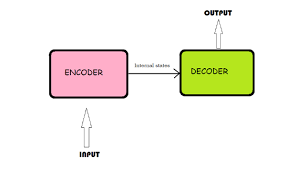

##         LSTM   Architecture

Meaning of a sentence is determined by neighbouring word
to keep a track of words which have similar context the cuuent input word is maintained by the cell memory

so it has a neural memory state to remember previous vectors

>solve vanishing gradient problem

>Avoid long term dependency

WHY LSTM

Rnn has only the knowledge about previous cell and it experiences vanishing gradient while backpropagating bcz gradient with respect to the error becomes small(nearly zero)

but lstm has all required knowledge on the concurrent previous cell 

# Components of LSTM
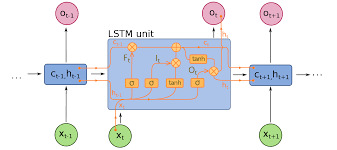

This is a simple implementation of Long short-term memory (LSTM) on numpy from scratch. 

The network is trained with stochastic gradient descent using AdaGrad algorithm (with momentum).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def dsig(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1-np.tanh(y)**2
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
def lookup(i):
    x=list(i)
    tk=(x.index(max(x)))
    global itow_tar
    return itow_tar[tk]
def lookups(i):
    x=list(i)
    tk=(x.index(max(x)))
    global itow_ip
    return itow_ip[tk]
def cal_MSE (y,y_hat):
    return np.sum((y_hat-y)**2)/y.size
    

In [3]:
class LSTM():
    def __init__(self,no_input,latent_dim,no_output,use_adagrad=True):
        
        # the inout for each cell is (previous time stamp hidden state,current time stamp input) stacked together horizontally
        x=no_input+latent_dim
        
        # initializing parameters
        params={}   
        
       
        # Xavier initialisation        
        xav=(1.0/np.sqrt(x))   
        self.params=params
        ld=latent_dim
        self.ld=ld
        
       
        self.params['wf']=np.random.randn(ld,x)*xav
        self.params['bf']=np.ones((ld,1))
        
        self.params['wi']=np.random.randn(ld,x)*xav
        self.params['bi']=np.ones((ld,1))
        
        self.params['wc']=np.random.randn(ld,x)*xav
        self.params['bc']=np.ones((ld,1))
        
        self.params['wo']=np.random.randn(ld,x)*xav
        self.params['bo']=np.ones((ld,1))
        
        self.params['wop']=np.random.randn(no_output, ld)* (2.0/np.sqrt(no_output+ld))
        self.params['bop']=np.ones((no_output,1))
        
        
        
        self.adagrad=use_adagrad
        
        self.grad = {}
        self.adam_params = {}
        self.momentum={}
        
        for i in params.keys():
            self.grad['d'+i]=np.zeros((params[i].shape))
            self.adam_params['ad'+i]=np.zeros((params[i].shape))
            self.momentum['m'+i]=np.zeros((params[i].shape))


### Forget gate
     
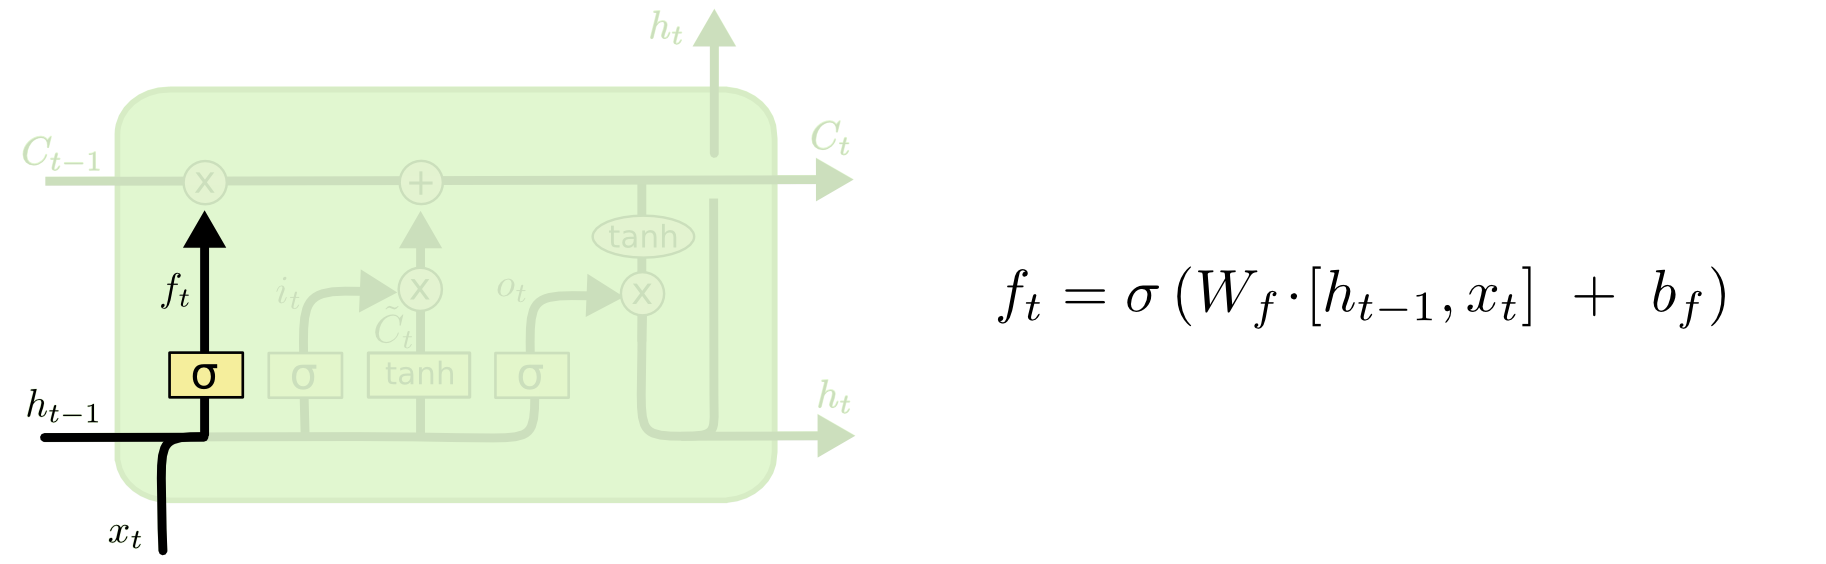
>how much past(previous cell state) should be rembered and forget

>sigmoid reslts between zero and one [1=> remember,0=>forget]

> it throw's away unwanted information according to context change

>if context changes a lot the gate will forget many of the information in the previous cell state

>the result is multiplied to the cell

### Input gate
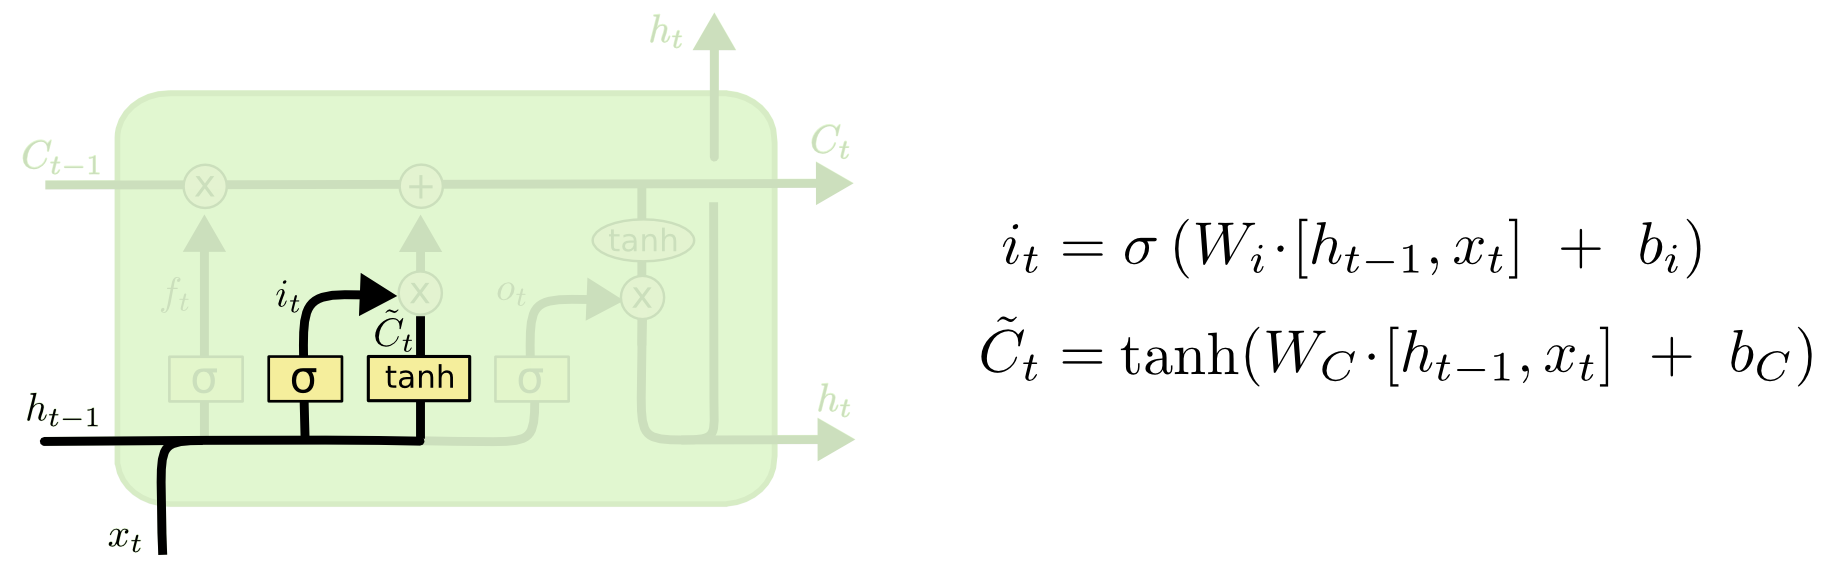

>what new knowledge should be gained (according to the input and previous hidden state) to the memory cell for                      current time stamp

>tanh gives the result between -1 and 1 

>sigmoid reslts between zero and one and [ 1=> gain,0=>leave]

>the above are multiplied

>tanh convert information sigmoid chooses it

>if context change is more in h_rev and input it adds more info to memory cell

>else it remains same

>the result is added to the cell

### output gate
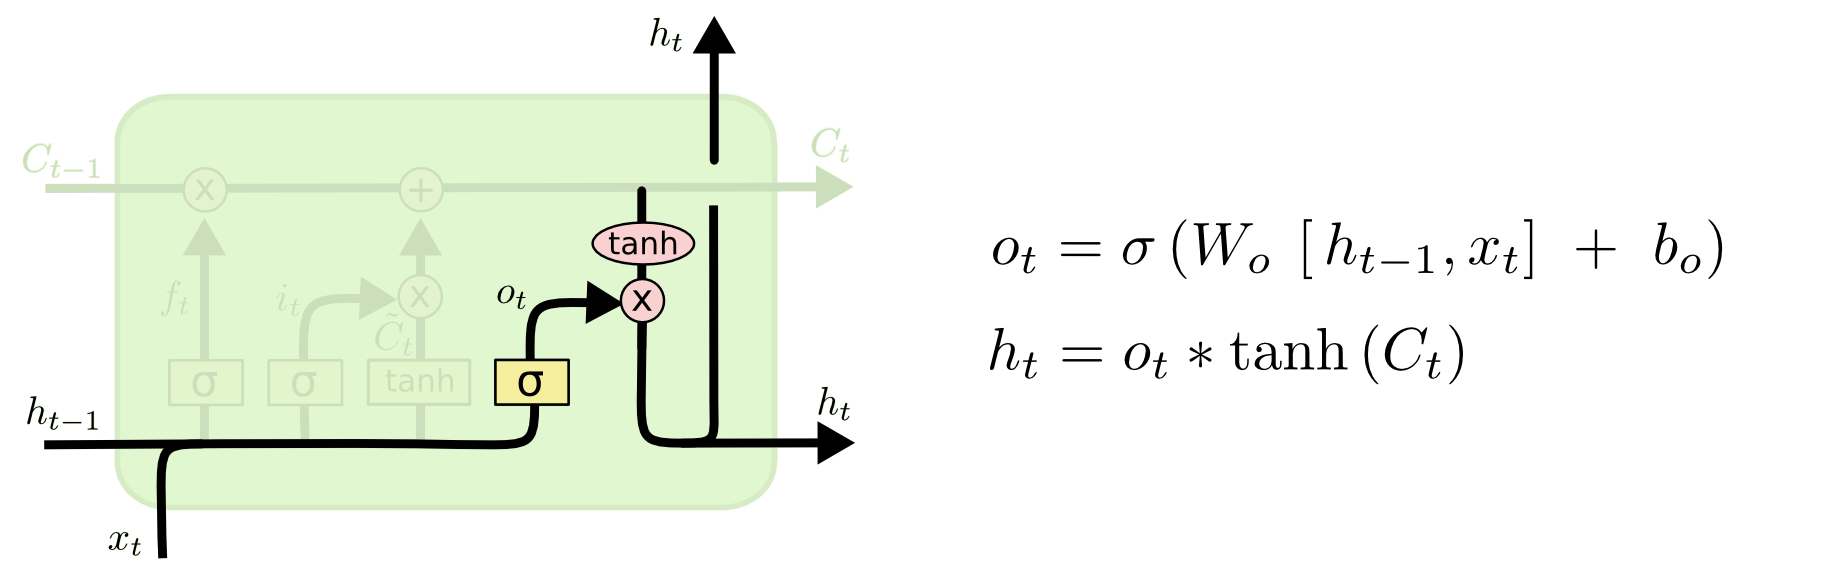

>what is the hidden state to be sent for next cell (ht) and for processing the output

>the whole memory cannot be given to process required information with current input and current cell state is processed to decide what should be given

>tanh gives the result between -1 and 1 

>sigmoid reslts between zero and one and [ 1=> take,0=>leave]

>the above are multiplied

>tanh convert information sigmoid chooses it




In [4]:
def forward(self,x_t,h_prev,c_prev):
    # initially stack input and h_prev so that gate can process their context
        
    z=np.row_stack((h_prev,(x_t.reshape(1,-1)).T))
    
    par=self.params
    
    f=sig(np.dot(par['wf'],z)+par['bf'])# forget gate
    
    i=sig(np.dot(par['wi'],z)+par['bi'])
    c_=tanh(np.dot(par['wc'],z)+par['bc'])# input gate
    
    c=f*c_prev+i*c_ # applying the gates to the memory cell
    
    o=sig(np.dot(par['wo'],z)+par['bo'])
    ht=o*tanh(c) #output gate
  
    v=np.dot(par['wop'],ht)+par['bop']
     
    y_hat=softmax(v)
                
    return y_hat,[ ht,c, o,  c_, i, f, z]

LSTM.forward=forward
        
        

#### steps for back_propagation

1. As weights are shared by all time steps, the weight gradients are accumulated.


        
2. We are adding dh_next to dh, because as Figure 1 shows,
h is branched in forward propagation in the softmax output layer and the next LSTM cell,
where it is concatenated with x. Therefore, 
there are two gradients flowing back.
This applies to dc as well.

           
3. There are four gradients flowing towards the input layer from the gates,
therefore dz is the summation of those gradients.

In [5]:
def backward(self,err,dh_next,dc_next,c_prev, param,use_op=True):
        dv=err
        [ h,c, o,  c_bar, i, f, z]=param
         #from the output
        if(use_op):
            self.grad['dwop']+=np.dot(dv,h.T) # 1 
            self.grad['dbop']+=dv # 2
            # hidden state        
            dh = np.dot(self.params["wop"].T, dv) # 3
            dh+=dh_next # accumulating the travelling parameters
        else:
            dh=dh_next
        
        
        ##########-----output gate-----###########
        do = dh * tanh(c) # 4
        d_ao=do*dsig(o) # 5
        
        self.grad["dwo"] += np.dot(d_ao, z.T) #6
        self.grad["dbo"] += d_ao# 7
        
        # cell state
        
        dc = dh * o * dtanh(c) #8
        dc += dc_next #9
        
        
       
        
        ##########-----input gate-----###########
        
        # tanh part
        dc_bar=dc* i#10
        dac=dc_bar*(1-c_bar**2)        
        self.grad["dwc"] += np.dot(dac, z.T) #11
        self.grad["dbc"] += dac# 12
        
        # sigmoid part
        di = dc * c_bar#13
        da_i = di * i*(1-i) #14
        self.grad["dwi"] += np.dot(da_i, z.T)#15
        self.grad["dbi"] += da_i#16
        
       
        
         ##########-----forget gate-----###########
        
        df = dc * c_prev  #17
        da_f = df * f*(1-f)#18
        self.grad["dwf"] += np.dot(da_f, z.T)#19
        self.grad["dbf"] += da_f#20
        dc_prev = f * dc#22
        
        
        
        dz = (np.dot(self.params["wf"].T, da_f)+ np.dot(self.params["wi"].T, da_i)+ np.dot(self.params["wc"].T, dac)+ np.dot(self.params["wo"].T, d_ao))   #As weights are shared by all time steps, the weight gradients are accumulated.
        dh_prev = dz[:self.ld, :]  #z=np.hstack((h_prev,x))  #21
        
        
        
        return dh_prev, dc_prev
     
    
    
    
LSTM.backward=backward

In [6]:
def cal_err(self,y,y_):
    return y_ - y
def update_param(self,lr):
        beta1=0.9
        beta2=0.999
        for key in self.params:
            if(self.adagrad): 
                self.momentum['m'+key]=beta1*self.momentum['m'+key]+(1-beta1)*self.grad['d'+key]
                self.adam_params['ad'+key]=beta2*self.adam_params['ad'+key]+(1-beta2) * self.grad["d"+key]**2            
            
                m_correlated = self.momentum["m" + key] / (1 - beta1)
                v_correlated = self.adam_params['ad'+key] / (1 - beta2) 
                self.params[key] -=lr * m_correlated / (np.sqrt(v_correlated) + 1e-8)
            else:
                self.params[key] -=lr * self.grad['d'+key]
            
#avoid exploding gradients
def clip_grads(self):
      for key in self.grad:
            np.clip(self.grad[key], -5, 5, out=self.grad[key])
# after each epoch reset the grads or gradient ofall epochs get accumulated
def reset_grads(self):
    for key in self.grad:         
         self.grad[key].fill(0)        
    return           
            
LSTM.cal_err=cal_err
LSTM.update_param=update_param
LSTM.clip_grads=clip_grads
LSTM.reset_grads=reset_grads



#testing lstm

x=[1,2,6,4,1,5,6,8,0,9]
err=[4,1,2,7,4,2,6,6,7,0]
# result must be 1.74345 h and 4.91062 c
param_Store={}
param_Store[-1]=[]
check=LSTM(1, 8, 1)
h_prev=np.zeros((8, 1))
c_prev=np.zeros((8, 1))
param_Store[-1]=[h_prev,c_prev]
for i in range(len(x)):
     y_hat,param=check.forward(x[i], h_prev, c_prev)
     h_prev=param[0]
     c_prev=param[1]
     param_Store[i]=param

dh_next1=np.zeros((8, 1))
dc_next1=np.zeros((8, 1))

for i in reversed(range(len(x))):
    dh_next1, dc_next1=check.back_propagation(err[i],dh_next1, dc_next1,param_Store[i-1][1],param_Store[i])
print(dh_next1, dc_next1)


# ENCODER
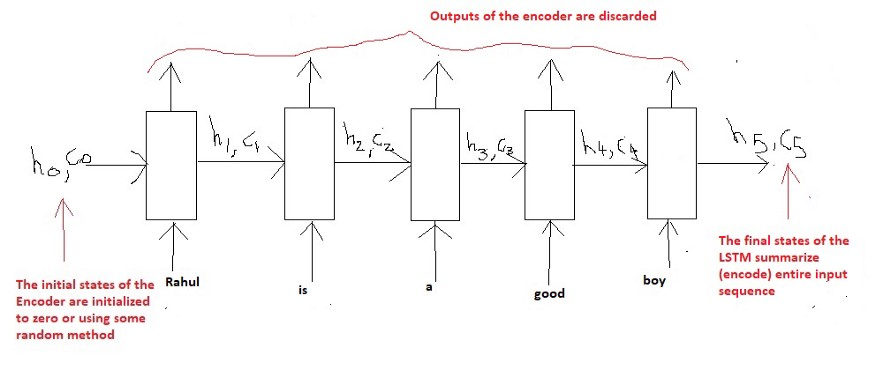

>encoder releases hidden state and cell state from the last layer of lstm

>those vectors are the thought vectors(summarized input vectors) for the decoder

>thought vectors size is size of the latent dimension

In [12]:

class ENCODER(LSTM):
    
    def __init__(self,no_input,latent_dim,no_output,use_adagrad=True):
        super().__init__(no_input,latent_dim,no_output)
        self.dim=latent_dim
        
    def forward_propagate(self,input_data,pr='not'):
        y_hat={}
        h_prev=np.zeros((self.dim, 1))
        c_prev=np.zeros((self.dim, 1))
        self.param_Store={}
        x_t=input_data
        self.seq_len=len(input_data)
        self.param_Store[-1]=[h_prev,c_prev]
        char_op=''
        for i in range(self.seq_len):
            y_hat[i],param=super().forward(x_t[i],h_prev,c_prev)
            h_prev=param[0]
            c_prev=param[1]
            char_op+=str(lookups(x_t[i]))
            self.param_Store[i]=param
        if(pr=='print'):
            print(char_op)  
        self.reset_grads()
        return y_hat,h_prev,c_prev
    def backward_propagate(self,dh_next,dc_next,lr,use_op=False):
        
        for i in reversed(range(self.seq_len)):
            dh_next, dc_next=super().backward(0,dh_next, dc_next,self.param_Store[i-1][1],self.param_Store[i],False)
        self.clip_grads()
        self.update_param(lr)
        return  self.param_Store[self.seq_len-1][0], self.param_Store[self.seq_len-1][1]


# DECODER
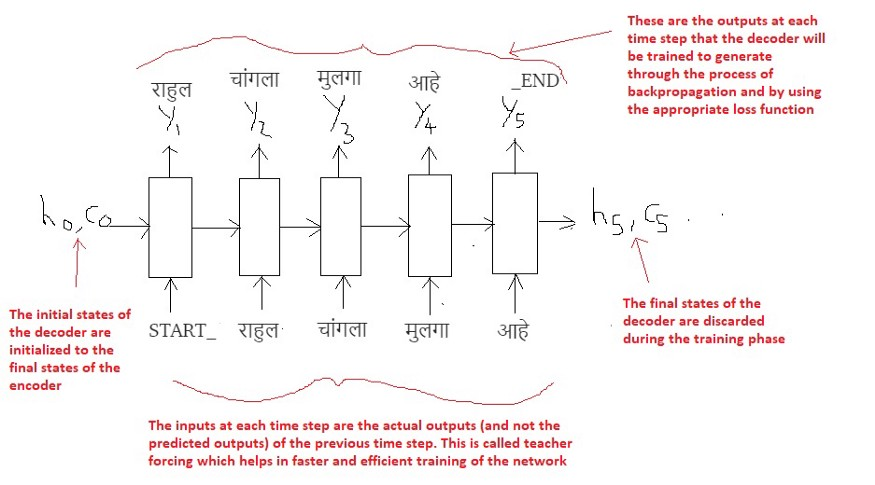

>the thought vector of encoder is fed to decoder

>decoder uses teacher forcing technique for training the layers

In [13]:

class DECODER(LSTM):
    def __init__(self,no_input,latent_dim,no_output,use_adagrad=True):
        super().__init__(no_input,latent_dim,no_output)
        self.dim=latent_dim
        
    def forward_propagate_train(self,input_data,h_enc,c_enc):
        y_hat={}
        h_prev=h_enc
        c_prev=c_enc
        self.param_Store={}
        x_t=input_data
        self.seq_len=len(input_data)
        self.param_Store[-1]=[h_prev,c_prev]
        char_op=''
        for i in range(self.seq_len):
            y_hat[i],param=super().forward(x_t[i],h_prev,c_prev)
            h_prev=param[0]
            c_prev=param[1]
            char_op+=str(lookup(y_hat[i]))
            
            self.param_Store[i]=param
            
        ###print(char_op)
        
        self.reset_grads()
        return y_hat,h_prev,c_prev
    def backward_propagate(self,y,y_hat,lr,use_op=True):
        dh_next=np.zeros((self.dim, 1))
        dc_next=np.zeros((self.dim, 1))
        loss=0
        
        
        for i in reversed(range(self.seq_len)):
            y_true=(y[i].reshape(1,-1)).T
            err=self.cal_err(y_true,y_hat[i])
            loss+=cal_MSE(y_true,y_hat[i])
            
           
            dh_next, dc_next=super().backward(err,dh_next, dc_next,self.param_Store[i-1][1],self.param_Store[i],True)
          
        self.clip_grads()
        self.update_param(lr)
        return  dh_next, dc_next,loss
    
    def forward_propagate_inference(self,h_enc,c_enc,start_vec,end_vec):
       
        h_prev=h_enc
        c_prev=c_enc
        self.param_Store={}
        xt=start_vec
        
        self.param_Store[-1]=[h_prev,c_prev]
        char=''
        for i in range(200):
            #print(h_prev,c_prev)
            xt,param=super().forward(xt,h_prev,c_prev)
            h_prev=param[0]
            c_prev=param[1]
            char+=str(lookup(xt))
                 
            if(lookup(xt)=='>'):
                break
        print(char)
       
        
        return h_prev,c_prev



In [17]:
class seq2seq():
    def __init__(self,source_lang_len,ld,target_lang_len):
        self.enc=ENCODER(source_lang_len,ld,source_lang_len)
        self.dec=DECODER(target_lang_len,ld,target_lang_len)
        self.target_lang_len=target_lang_len
    def fit(self,x_train,y_train,y_op,epochs,lr=0.001):
        J=[]
        self.smooth_loss = -np.log(1.0 / self.target_lang_len) * len(y_train[0])
        assert(len(x_train)==len(y_train))
        
        for epc in range(epochs):
            losses=[]
            for i in range (len(x_train)):
            
                y_hat_source,h_prev,c_prev=self.enc.forward_propagate(x_train[i])
                y_hat_target,h_prev,c_prev=self.dec.forward_propagate_train(y_train[i],h_prev,c_prev)
            
                
            
                dh_next, dc_next,loss=self.dec.backward_propagate(y_op[i],y_hat_target,lr,use_op=True)
                h,c=self.enc.backward_propagate(dh_next,dc_next,lr,use_op=False)
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                losses.append(loss)
                J.append(self.smooth_loss)
            print('\nEpoch:', epc,'seq',i, round((sum(losses)/len(losses)), 7))
    def predict(self,x_test,start,end):
        
        for i in range (len(x_test)):           
            _,h_prev,c_prev=self.enc.forward_propagate(x_test[i],'print')
            #print(h_prev,c_prev)
            h_prev,c_prev=self.dec.forward_propagate_inference(h_prev,c_prev,start,end)
            
           


In [15]:
f=open('fra.txt')
num_samples=100
input_text=[]
target_text=[]

input_char=set()
target_char=set()

lines=f.read().split('\n')
for line in lines[:num_samples]:
    src,tar,_=line.split('\t')
    
    src=re.sub(r'\W+', ' ', src)  
    tar=re.sub(r'\W+', ' ', tar)
    x='<'+tar+'>'
    input_text.append(src)
    target_text.append(x)

    for char in src:
        input_char.add(char)
    for char in tar:
        target_char.add(char) 
    
    
target_char.add('<') # start token
target_char.add('>') # end token

eng_words=list(input_char)
fre_words=list(target_char)



max_seq_len_enc=max([len(text) for text in input_text])
max_seq_len_dec=max([len(text) for text in target_text])

num_seq_enc=len(input_text)
num_seq_dec=len(target_text)

char2id_ip={w:i for i,w in enumerate(eng_words)} 
char2id_tar={w:i for i,w in enumerate(fre_words)} 


num_enc_tokens=len(eng_words)
num_dec_tokens=len(fre_words)




 encoder has input data (i,e) input text  with max_Seq_len no_Seq  and one hot represention of that with size(num_enc_tokens)                        
 decoder has input and output (i,e) predicted from prev context and  predicted text  with max_Seq_len no_Seq  and one hot represention of that with size(num_enc_tokens)                        

      vec(h)   vec(o)   vec(w)   vec(a)   vec(r)   vec(r)  vec(y)   vec(o)   vec(u)
              
             vec(i)   vec(a)   vec(m)   vec(g)   vec(o)   vec(o)  vec(o)   vec(d)   
                                                                                                 ]
    
    each vector vec() is one hot representation of the letter
    

In [17]:

encoder_input=np.zeros((num_seq_enc,max_seq_len_enc,num_enc_tokens))
decoder_input=np.zeros((num_seq_dec,max_seq_len_dec,num_dec_tokens))
decoder_output=np.zeros((num_seq_dec,max_seq_len_dec,num_dec_tokens))


for i,(inp_txt,tar_txt) in enumerate(zip(input_text,target_text)):
    for j,tok in enumerate(inp_txt):
        
        encoder_input[i,j,char2id_ip[tok]]=1
        
        
    encoder_input[i,j+1:,char2id_ip[' ']]=1
    for j,tok in enumerate(tar_txt):
        decoder_input[i,j,char2id_tar[tok]]=1
        if(j>=1):
            decoder_output[i,j-1,char2id_tar[tok]]=1
    decoder_input[i,j+1:,char2id_tar[' ']]=1
    decoder_output[i,j:,char2id_tar[' ']]=1
itow_tar={i:w for i,w in enumerate(fre_words)}  
itow_ip={i:w for i,w in enumerate(eng_words)}  

# latent dimension is vvery very important to get best resuts
model=seq2seq(num_enc_tokens, 256, num_dec_tokens)
model.fit(encoder_input,decoder_input,decoder_output,200)




Epoch: 0 seq 999 0.239175

Epoch: 1 seq 999 0.1933675

Epoch: 2 seq 999 0.1804114

Epoch: 3 seq 999 0.1728537

Epoch: 4 seq 999 0.1665913

Epoch: 5 seq 999 0.1610533

Epoch: 6 seq 999 0.1562093

Epoch: 7 seq 999 0.1517669

Epoch: 8 seq 999 0.1472465

Epoch: 9 seq 999 0.1431398

Epoch: 10 seq 999 0.1387387

Epoch: 11 seq 999 0.1341558

Epoch: 12 seq 999 0.1295216

Epoch: 13 seq 999 0.1249899

Epoch: 14 seq 999 0.1204139

Epoch: 15 seq 999 0.1157616

Epoch: 16 seq 999 0.1113218

Epoch: 17 seq 999 0.1071913

Epoch: 18 seq 999 0.1035525

Epoch: 19 seq 999 0.0989829

Epoch: 20 seq 999 0.0955531

Epoch: 21 seq 999 0.0916535

Epoch: 22 seq 999 0.0880155

Epoch: 23 seq 999 0.0851775

Epoch: 24 seq 999 0.0819826

Epoch: 25 seq 999 0.0793112

Epoch: 26 seq 999 0.0768753

Epoch: 27 seq 999 0.0745107

Epoch: 28 seq 999 0.072498

Epoch: 29 seq 999 0.0699231

Epoch: 30 seq 999 0.0680574

Epoch: 31 seq 999 0.0660337

Epoch: 32 seq 999 0.0655443

Epoch: 33 seq 999 0.0640685

Epoch: 34 seq 999 0.06230

In [18]:
x_Test=encoder_input[1:80]

  
st=np.zeros((len(char2id_tar)))
st[char2id_tar['<']]=1 #vector of start condition  

nd=np.zeros((len(char2id_tar)))
nd[char2id_tar['>']]=1   #vector of  end condition 

model.predict(x_Test,st,nd)

Hi        
Salut >
Hi        
Salut >
Run       
Coursâ >
Run       
Coursâ >
Who       
Qui >
Wow       
Ã a alorsâ >
Fire      
Au feu >
Help      
Ã l aideâ >
Jump      
Saute >
Stop      
AroÃ te le rierr >
Stop      
AroÃ te le rierr >
Stop      
AroÃ te le rierr >
Wait      
Attendez >
Wait      
Attendez >
Go on     
Poursuis >
Go on     
Poursuis >
Go on     
Poursuis >
Hello     
Bonjour >
Hello     
Bonjour >
I see     
Je comprends >
I try     
J essaye >
I won     
Jâ ai fait ii le >
I won     
Jâ ai fait ii le >
I won     
Jâ ai fait ii le >
Oh no     
Oh non >
Attack    
Attaquez >
Attack    
Attaquez >
Cheers    
Tcnci >
Cheers    
Tcnci >
Cheers    
Tcnci >
Cheers    
Tcnci >
Get up    
LÃ ve toi >
Go now    
Aasez vous en rrerre >
Go now    
Aasez vous en rrerre >
Go now    
Aasez vous en rrerre >
Got it    
Compaid >
Got it    
Compaid >
Got it    
Compaid >
Got it    
Compaid >
Got it    
Compaid >
Hop in    
Monte >
Hop in    
Monte >
Hug me    
Serre mmon dans s av